In [ ]:
%pip install numpy

In [ ]:
%pip install pandas

In [ ]:
%pip install networkx

In [ ]:
%pip install matplotlib

In [ ]:
%pip install tqdm

In [342]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from tqdm import tqdm
from networkx.drawing.nx_pydot import graphviz_layout
from collections import Counter

# Base para todos

## Kalebe implementations

exponential mechanism

In [338]:
def exp_mechanism_k(data, score_func, list_outputs, epsilon, global_sensivity, target = None):
    scores = [score_func(data, out, target) if target != None else score_func(data, out) for out in list_outputs]
    probs = [np.exp(epsilon * score / (2 * global_sensivity)) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)

    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

local dampening mechanism

In [426]:
def dampening_function_k(data, output, score_func, delta_func, target = None):
    b_i = 0
    i = 0  
    b_ipp = delta_func(data, i, output) if target == None else delta_func(data, i, output, target)
    score = score_func(data, output, target) if target != None else score_func(data, output)
    while True:
        # print("dampening ad distance: ", i)
        # print(f"utility value: : {score}\nb0: {b_i}\nb1: {b_ipp}\noutput now: {output}\n")
        if (score >= 0 and (score < b_i or score >= b_ipp)) or (score < 0 and (score < -b_ipp or score >= -b_i)):
            i += 1
            b_i = b_ipp
            d_func = delta_func(data, i, output) if target == None else delta_func(data, i, output, target)
            b_ipp = b_ipp + d_func
            continue
        
        print("Retornou", i, -b_i, -b_ipp, score)
        return (score - b_i) / (b_ipp - b_i) + i if score > 0 else (score + b_i) / (-b_ipp + b_i) - i

def local_dampening_mechanism_k(data, score_func, delta_func, list_outputs, epsilon, target = None):
    scores = [dampening_function_k(data, out, score_func, delta_func, target) if target != None else dampening_function_k(data, out, score_func, delta_func) for out in list_outputs]
    # print(scores)
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    # print(probs_normalizadas)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

permute and flip mechanism

In [301]:
def permute_and_flip_k(data, score_func, list_outputs, epsilon, global_sensivity):
    max_score = max([score_func(data, out) for out in list_outputs])
    # aqui talvez seja interessante copiar e passar a copia da list_ouputs
    np.random.shuffle(list_outputs)
    for r in list_outputs:
        prob = np.exp(epsilon * (score_func(data, r) - max_score) / (2 * global_sensivity))
        if np.random.rand() < prob:
            return r

## Darlan implementations

local dampening mechanism

In [368]:
def dampening_function_d(G, r_id, u_r, sensibilidade, target = None):
    # print(u_r)
    if u_r >= 0:
        
        t = 0
        bt0 = 0
        bt1 = sensibilidade(G, t, r_id, target) if target != None else sensibilidade(G, t, r_id)
        
        while True:
            # print(bt1)
            # print("dampening ad distance: ", t)
            # print(f"utility value: : {u_r}\nb0: {bt0}\nb1: {bt1}\noutput now: {r_id}\n")
            if ((bt0 <= u_r) and  (u_r < bt1)):
                break
            
            t += 1
            bt0 = bt1
            bt1 += sensibilidade(G, t, r_id, target) if target != None else sensibilidade(G, t, r_id)
            
    elif u_r < 0:

        t = 0
        bt0 = 0
        bt1 = -sensibilidade(G, t, r_id, target) if target != None else sensibilidade(G, t, r_id)
        
        while True:

            if ((bt1 <= u_r) and  (u_r < bt0)):
                break
            
            t -= 1
            bt0 = bt1
            bt1 -= sensibilidade(G, t, r_id, target) if target != None else sensibilidade(G, t, r_id)
    
    D = (u_r - bt0) / (bt1 - bt0) + t
    
    return D

def local_dampening_mechanism_d(data, score_func, delta_func, list_outputs, epsilon, target = None):
    scores = [dampening_function_d(data, out, score_func(data, out, target), delta_func, target) if target != None else dampening_function_d(data, out, score_func(data, out), delta_func) for out in list_outputs]
    # print(scores)
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

permute and flip mechanism

In [ ]:
def permute_and_flip_d(epsilon, u, R):
    permuted_indices = np.random.permutation(len(R))
    # print(R)
    # print(u)
    permuted_R = [R[i] for i in permuted_indices]
    permuted_u = [u[i] for i in permuted_indices]
    
    u_max = max(permuted_u)
    
    for r, u_i in zip(permuted_R, permuted_u):
        pr = np.exp(epsilon / (2 * (u_i - u_max)))
        
        if np.random.rand() < pr:
            return R.index(r)


# Algoritmo 7

In [216]:
def get_canditates(data, t, value_column, target, coluna, label):
    # se a distancia for 0
    if t == 0:
      # dataframe onde o atributo A possui valor j
      ## no caso, a coluna possui value_column
      qtd_T_value_columnA = data[data[coluna] == value_column]
      # dataframe onde o atributo A possui valor j e alvo é c de C
      ## no caso, a coluna possui value_column e o label é oque procuramos
      value_columnA_target = qtd_T_value_columnA[qtd_T_value_columnA[target] == label]

      return [(qtd_T_value_columnA.shape[0], value_columnA_target.shape[0])]
    candidates = get_canditates(data, t-1, value_column, target, coluna, label)
    validos_candidates = []

    for candidato in candidates:
      if candidato[0] > 0 and candidato[1] > 0:
        validos_candidates.append((candidato[0] - 1, candidato[1] - 1))
      if candidato[0] < data.shape[0]:
        validos_candidates.append((candidato[0] + 1, candidato[1]))

    return validos_candidates

def h_func(x, y):
    def f_func(x, somar = False):
        return x * np.log2((x + 1) / x) + np.log2(x + 1) if somar else x * np.log2((x - 1) / x) - np.log2(x - 1)
    return max(f_func(x, True) - f_func(y, True), f_func(x) - f_func(y))

def local_sensivity_at_tDistance_alg7(data:pd.DataFrame, t:float, col_val, target):
    '''
    data = dataframe

    t = distâncuia

    col_val = uma coluna do dataframe

    target_values = lista com todas saídas possíveis do label
    '''

    H = []
  
    for i in range(t + 1):
      for a in data[col_val].unique():
        for c in data[target].unique():
          candidatos = get_canditates(data, i, a, target, col_val, c)
          for tup in candidatos:
             H.append(tup)
    
    # verifica se é 0 ou 1
    def verify(x):
       if x == 0 or x == 1:
          return False
       return True
    
    return max([h_func(x, y) if (verify(x) and verify(y)) else 0. for x, y in H])

In [302]:
my_data = pd.read_csv("./data_uci.csv")
my_data.drop(columns = ["job number", "timestamp", "cylinder number"], inplace=True)
# for c in my_data.columns:
#     print(len(my_data[c].unique()), c)
# 
my_data.dropna(inplace=True)
my_data


# print(my_data.columns)

,customer,grain screened,ink color,proof on ctd ink,blade mfg,cylinder division,paper type,ink type,direct steam,solvent type,...,solvent pct,esa voltage,esa amperage,wax,hardener,roller durometer,current density,anode space ratio,chrome content,band type
0,TVGUIDE,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,...,36.4,0.0,0.0,2.5,1.0,34.0,40.0,105.00,100.0,band
3,MASSEY,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,...,38.8,0.0,0.0,2.5,1.3,40.0,40.0,108.06,100.0,noband
5,MASSEY,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,...,37.6,5.0,0.0,2.5,0.8,40.0,40.0,103.87,100.0,noband
6,ROSES,NO,KEY,YES,BENTON,GALLATIN,COATED,COATED,NO,LINE,...,37.5,6.0,0.0,2.5,0.6,30.0,40.0,106.67,100.0,noband
7,ROSES,NO,KEY,YES,BENTON,GALLATIN,COATED,COATED,NO,LINE,...,37.5,6.0,0.0,2.5,1.1,30.0,40.0,106.67,100.0,noband
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,AMES,NO,KEY,YES,BENTON,GALLATIN,COATED,COATED,NO,LINE,...,41.2,8.0,0.0,3.0,1.0,33.0,40.0,106.45,100.0,noband
426,ECKERDS,NO,KEY,YES,BENTON,GALLATIN,COATED,COATED,NO,LINE,...,37.5,1.0,0.0,2.5,1.5,30.0,40.0,106.45,100.0,noband
427,ECKERDS,NO,KEY,YES,BENTON,GALLATIN,COATED,COATED,NO,LINE,...,39.5,4.5,0.0,1.9,1.3,30.0,40.0,114.28,100.0,noband
428,DOWNS,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,NO,LINE,...,36.1,4.0,0.0,3.0,1.0,40.0,40.0,117.85,100.0,noband


In [459]:
def noisy_count(data: pd.DataFrame, target, epsilon):
    '''
    Calcula uma estimativa ruidosa da contagem da coluna alvo (target) do dataframe usando o mecanismo NoisyCount.
    
    Parâmetros:
        data (pd.DataFrame): O dataframe contendo os dados.
        target (str): O nome da coluna alvo.
        epsilon (float): O parâmetro de privacidade epsilon para o mecanismo NoisyCount.
    
    Retorna:
        float: A contagem ruidosa da coluna alvo.
    '''
    # Contagem exata da coluna alvo
    exact_count = data[target].count()
    
    noise = np.random.laplace(scale=1/epsilon)
    
    # Adicionar o ruído ao contador exato
    noisy_count = exact_count + noise
    
    return noisy_count

# Equação 7.2
def score_func_exp(data: pd.DataFrame, r, target):
    '''
    r = uma coluna específica do dataframe
    '''
    infGain_list = []
    for c in data[target].unique():
      for a in data[r].unique():
        data_colR_valA = data[data[r] == a]
        data_colR_valA_outC = data_colR_valA[data_colR_valA[target] == c]
        tau_jc = data_colR_valA_outC.shape[0]
        tau_j = data_colR_valA.shape[0]
        if tau_jc == 0 or tau_j == 0:
            infGain_list.append(0.)
            continue 
        infGain_list.append(tau_jc * np.log2(tau_jc / tau_j))

    # print(infGain_list)
    return -sum(infGain_list)

def build_diff_PID3(data:pd.DataFrame, list_columns: list, target, profundidade, epsilon):
    data_target_list = data[target].unique()
    if len(list_columns) == 0 or profundidade == 0:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        max_Nc = max(data_output_partitions)
        return (data_target_list[data_output_partitions.index(max_Nc)]) 
    t_val = max([len(data[col].unique()) for col in list_columns])
    N_t = noisy_count(data, target, epsilon)
    if N_t / (t_val * len(data_target_list)) < np.sqrt(2)/2:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        max_Nc = max(data_output_partitions)
        return (data_target_list[data_output_partitions.index(max_Nc)]) 
        
    columns_hat = exp_mechanism_k(data, score_func_exp, list_columns, epsilon, np.log2(data.shape[0] + 1) + 1/np.log(2), target)
    # columns_hat = local_dampening_mechanism_k(data, score_func_exp, local_sensivity_at_tDistance_alg7, list_columns, epsilon, target)
    # columns_hat = local_dampening_mechanism_d(data, score_func_exp, local_sensivity_at_tDistance_alg7, list_columns, epsilon, target)
    data_i = [(data[data[columns_hat] == i], i ) for i in data[columns_hat].unique()]
    list_columns.remove(columns_hat)
    arvore = []
    for dado in data_i:
        root_node = build_diff_PID3(dado[0], list_columns, target, profundidade - 1, epsilon)
        arvore.append({
            "from": columns_hat,
            "to": root_node,
            "edge_name": dado[1]
        })
    
    return arvore

def global_diff_PID3(data:pd.DataFrame, target, profundidade: int, privacy_budget: float):
    '''
    data = um dataframe
    target = a coluna alvo, no exemplo do tempo, seria o Y e o N
    profundidade = numero que indica a profuntidade
    privacy_budget = nivel de privacidade numero
    '''
    epsilon = privacy_budget / (2 * (profundidade + 1))
    lista_colunas = data.columns.to_list()
    lista_colunas.remove(target)
    # print(data, lista_colunas, target, profundidade, epsilon)
    return build_diff_PID3(data, lista_colunas, target, profundidade, epsilon)

# Atribua um valor de privacidade para o orçamento de privacidade
epsilon = 100

# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde = global_diff_PID3(my_data, "band type", 3, epsilon)

Nesse caso, se o epsilon for muito grande, o score cresce para infinito e se for muito pequeno retorna somente um nó (no mecanismo exponencial, o outro nem roda)

                |_proof on ctd ink---YES--->noband
                |_proof on ctd ink---NO--->noband
                |_paper type---UNCOATED--->noband
                |_hardener---1.2--->noband


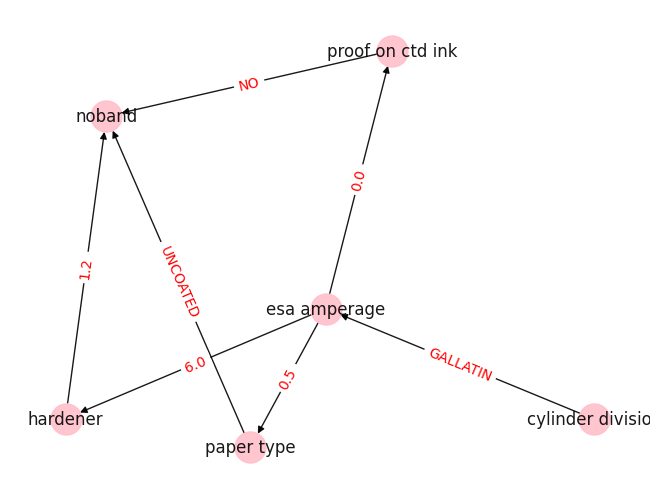

[{'from': 'cylinder division', 'to': [{'from': 'esa amperage', 'to': [{'from': 'proof on ctd ink', 'to': 'noband', 'edge_name': 'YES'}, {'from': 'proof on ctd ink', 'to': 'noband', 'edge_name': 'NO'}], 'edge_name': 0.0}, {'from': 'esa amperage', 'to': [{'from': 'paper type', 'to': 'noband', 'edge_name': 'UNCOATED'}], 'edge_name': 0.5}, {'from': 'esa amperage', 'to': [{'from': 'hardener', 'to': 'noband', 'edge_name': 1.2}], 'edge_name': 6.0}], 'edge_name': 'GALLATIN'}]


In [460]:
# nx.draw(arvore)
# plt.show()

def molde2draw(molde):
    G = nx.DiGraph()
    lista_labels = {}

    def add_edge(from_name, to_name, edge_label):
        if isinstance(to_name, list):
            for item in to_name:
                to_name = item["from"]
                add_edge(item["from"], item["to"], item["edge_name"])
            
        G.add_edge(from_name, to_name)
        lista_labels[(from_name, to_name)] = edge_label

    for dict_node in molde:
        add_edge(dict_node["from"], dict_node["to"], dict_node["edge_name"])

    pos = nx.spring_layout(G)
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='pink', alpha=0.9,
        labels={node: node for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=lista_labels,
        font_color='red'
    )
    plt.axis('off')
    plt.show()

def print_tree(tree, indent=0):
    if isinstance(tree, list):
        for item in tree:
            print_tree(item, indent)
    else:
        to_node = tree.get('to', '')
        if isinstance(to_node, list):
            print_tree(to_node, indent + 1)
            return
        from_node = tree.get('from', '')
        edge_name = tree.get('edge_name', '')
        print('  ' * (4*indent) + f"|_{from_node}---{edge_name}--->{to_node}")

# print(arvore_molde)
print_tree(arvore_molde)
molde2draw(arvore_molde)
print(arvore_molde)

                                                |_plating tank---1911.0--->noband
                                                        |_type on cylinder---NO--->noband
                                                                        |_solvent type---LINE--->noband
                                                                        |_solvent type---XYLOL--->band
                                                                        |_proof cut---50.0--->noband
                                                                        |_varnish pct---0.0--->noband
                                                                        |_roughness---0.75--->noband
                                        |_esa voltage---4.0--->noband
                                                                        |_customer---ROSES--->noband
                                                        |_humidity---80.0--->noband
                                                              

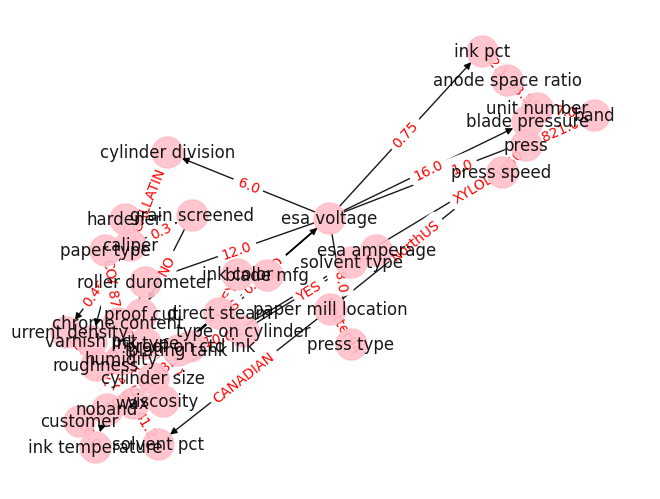

[{'from': 'cylinder size', 'to': [{'from': 'proof on ctd ink', 'to': [{'from': 'blade mfg', 'to': [{'from': 'ink color', 'to': [{'from': 'direct steam', 'to': [{'from': 'esa voltage', 'to': [{'from': 'plating tank', 'to': 'noband', 'edge_name': 1911.0}, {'from': 'plating tank', 'to': [{'from': 'type on cylinder', 'to': 'noband', 'edge_name': 'NO'}, {'from': 'type on cylinder', 'to': [{'from': 'esa amperage', 'to': [{'from': 'solvent type', 'to': 'noband', 'edge_name': 'LINE'}, {'from': 'solvent type', 'to': 'band', 'edge_name': 'XYLOL'}], 'edge_name': 0.0}], 'edge_name': 'YES'}], 'edge_name': 1910.0}], 'edge_name': 0.0}, {'from': 'esa voltage', 'to': [{'from': 'cylinder division', 'to': [{'from': 'caliper', 'to': [{'from': 'grain screened', 'to': [{'from': 'proof cut', 'to': 'noband', 'edge_name': 50.0}], 'edge_name': 'NO'}], 'edge_name': '0.3'}, {'from': 'caliper', 'to': [{'from': 'hardener', 'to': [{'from': 'varnish pct', 'to': 'noband', 'edge_name': 0.0}], 'edge_name': 1.1}], 'edge_

In [461]:
# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde = global_diff_PID3(my_data, "band type", 10, epsilon)

# print(arvore_molde)
print_tree(arvore_molde)
molde2draw(arvore_molde)
print(arvore_molde)

# Algoritmo 5

saida: o indíce do valor mais próximo da mediana

entrada: vetor x, com todos valores entre 0 e $\Lambda$

In [449]:
def local_sensivity_at_0(x:list, idx:int):
    m = int(np.ceil(len(x)/2))
    def p(x, i):
        if i > m:
            return max(x) - x[i]
        if i == m:
            return max(x) - x[m + 1]
        return max(x) + x[i] - 3 * x[m] + x[m + 1]
    def q(x,i):
        if i > m:
            return x[i]
        if i == m:
            return x[m - 1]
        return 3 * x[m] - x[m - 1] - x[i]
    
    values = [np.abs(x[m] - x[idx]), x[m + 1] - x[m], x[m] - x[m - 1], p(x,idx), q(x,idx)]

    return max(values)
    
def get_canditates_alg5(x, t, idx):
    if t == 0:
        return [x]
    m = int(np.ceil(len(x)/2))
    if t == 1:
        X = [x.copy() for i in range(6)]
        X[0][-1] = x[idx]
        X[1] = X[0].copy()
        X[2][0] = x[idx]
        X[3] = X[2].copy()
        X[4][-1] = x[m]
        X[5][0] = x[m]
        return X
    X = get_canditates_alg5(x, t - 1, idx)
    X[0][0] = X[0][m]
    X[1][-1] = X[1][m]
    X[2][0] = X[2][m]
    X[3][-1] = X[3][m]
    X[4][0] = X[4][m]
    X[5][-1] = X[5][m]
    return X

def local_sensivity_at_tDistance(x, t, i):
    list_candidates = get_canditates_alg5(x, t, i)
    return max([local_sensivity_at_0(candidate, i) for candidate in list_candidates])

def score_func(x, idx):
    m = int(np.ceil(len(x)/2))
    return -np.abs(x[m] - x[idx])

In [435]:
n_array = 30
array_aleatorio = np.sort(np.random.randint(0, 101, n_array))
epsilon = 100
# delta u
max_u = max(array_aleatorio)
n_amostras = 10000
list_outputs = [i for i in range(n_array)]
# delta star
max_utility = max(score_func(array_aleatorio, i) for i in range(n_array))

## Avalaiando

In [436]:
def avaliation(x, score_func, list_outputs, epsilon_range, max_u = None, n_amostras = 10000, typo_mech = "exp"):
    evaluate = {}
    for epsilon in tqdm(epsilon_range, desc="Processando epsilons", unit=" valor"):
        if typo_mech == "exp":
            evaluate[epsilon] = [exp_mechanism_k(x, score_func, list_outputs, epsilon, max_u) for i in range(n_amostras)]
        elif typo_mech == "paf":
            evaluate[epsilon] = [permute_and_flip_k(x, score_func, list_outputs, epsilon, max_u) for i in range(n_amostras)]
        
    return evaluate

epsilons = np.linspace(10**-3, 10**3, 10)

### exponencial mechanism

In [456]:
evalueate_exp = avaliation(array_aleatorio, score_func, list_outputs, epsilons, max_u, typo_mech = "exp")

Processando epsilons: 100%|██████████| 10/10 [00:21<00:00,  2.20s/ valor]


In [457]:
for ep, err in evalueate_exp.items():
    frequencia = Counter(err)
    print(f"epsilon: {ep}\nfrequency: {dict(frequencia)}\n")

epsilon: 0.001
frequency: {15: 334, 17: 335, 16: 334, 7: 327, 9: 314, 23: 329, 12: 344, 22: 323, 21: 332, 3: 362, 26: 356, 8: 348, 18: 331, 27: 315, 2: 323, 19: 315, 29: 348, 0: 338, 6: 320, 20: 337, 5: 305, 4: 336, 24: 327, 1: 330, 14: 339, 28: 329, 10: 337, 25: 346, 11: 346, 13: 340}

epsilon: 111.11200000000001
frequency: {14: 2841, 15: 4873, 13: 1696, 16: 265, 17: 151, 18: 167, 12: 1, 11: 3, 19: 3}

epsilon: 222.223
frequency: {13: 759, 14: 2249, 15: 6959, 16: 20, 18: 6, 17: 7}

epsilon: 333.334
frequency: {15: 8240, 14: 1472, 13: 286, 18: 1, 17: 1}

epsilon: 444.445
frequency: {15: 8982, 14: 932, 13: 86}

epsilon: 555.556
frequency: {15: 9436, 14: 531, 13: 33}

epsilon: 666.667
frequency: {15: 9645, 14: 344, 13: 11}

epsilon: 777.778
frequency: {15: 9792, 14: 207, 13: 1}

epsilon: 888.889
frequency: {15: 9899, 14: 99, 13: 2}

epsilon: 1000.0
frequency: {15: 9937, 14: 62, 13: 1}



### permuta and flip

In [439]:
evalueate_paf = avaliation(array_aleatorio, score_func, list_outputs, epsilons, max_u, typo_mech = "paf")

Processando epsilons: 100%|██████████| 10/10 [00:17<00:00,  1.72s/ valor]


In [458]:
for ep, err in evalueate_paf.items():
    frequencia = Counter(err)
    print(f"epsilon: {ep}\nfrequency: {dict(frequencia)}\n")

epsilon: 0.001
frequency: {1: 321, 16: 340, 28: 327, 18: 348, 17: 370, 26: 314, 29: 323, 20: 342, 24: 333, 25: 332, 14: 345, 4: 329, 6: 312, 11: 326, 12: 314, 8: 326, 15: 323, 27: 357, 10: 350, 21: 317, 9: 326, 2: 322, 13: 330, 19: 330, 22: 334, 23: 355, 3: 339, 0: 337, 7: 380, 5: 298}

epsilon: 111.11200000000001
frequency: {14: 2321, 16: 204, 13: 1248, 15: 5937, 18: 145, 17: 137, 19: 6, 11: 1, 12: 1}

epsilon: 222.223
frequency: {15: 7971, 14: 1564, 16: 17, 13: 434, 17: 10, 18: 4}

epsilon: 333.334
frequency: {15: 8908, 14: 928, 13: 162, 16: 2}

epsilon: 444.445
frequency: {15: 9414, 14: 536, 13: 50}

epsilon: 555.556
frequency: {15: 9734, 14: 248, 13: 18}

epsilon: 666.667
frequency: {15: 9836, 14: 161, 13: 3}

epsilon: 777.778
frequency: {15: 9922, 14: 77, 13: 1}

epsilon: 888.889
frequency: {15: 9942, 14: 57, 13: 1}

epsilon: 1000.0
frequency: {15: 9966, 14: 34}



### Local Dampening

In [453]:
epsilon = 10 **3
experimentations_ld_d = [local_dampening_mechanism_k(array_aleatorio, score_func, local_sensivity_at_tDistance, [i for i in range(n_array)], epsilon) for j in range(10)]
print(f"local_dampening returned indicex: \t{experimentations_ld_d}\nepsilon: {epsilon}")
# experimentations_ld_d = [local_dampening_mechanism_d(x, score_func, local_sensivity_at_tDistance, [i for i in range(len(x))], epsilon) for j in range(2)]
# print(f"local_dampening epsilon{epsilon}: \t", experimentations_ld_d)

Retornou 0 0 -87 -43
Retornou 0 0 -81 -37
Retornou 0 0 -80 -36
Retornou 0 0 -80 -36
Retornou 0 0 -78 -34
Retornou 0 0 -76 -32
Retornou 0 0 -73 -29
Retornou 0 0 -71 -27
Retornou 0 0 -70 -26
Retornou 0 0 -69 -25
Retornou 0 0 -63 -19
Retornou 0 0 -59 -15
Retornou 0 0 -58 -14
Retornou 0 0 -58 -2
Retornou 0 0 -59 -1
Retornou 0 0 -50 0
Retornou 0 0 -50 -5
Retornou 0 0 -49 -6
Retornou 0 0 -49 -6
Retornou 0 0 -56 -13
Retornou 0 0 -74 -31
Retornou 0 0 -79 -36
Retornou 0 0 -81 -38
Retornou 0 0 -86 -43
Retornou 0 0 -87 -44
Retornou 0 0 -88 -45
Retornou 0 0 -89 -46
Retornou 0 0 -93 -50
Retornou 0 0 -95 -52
Retornou 0 0 -98 -55
Retornou 0 0 -87 -43
Retornou 0 0 -81 -37
Retornou 0 0 -80 -36
Retornou 0 0 -80 -36
Retornou 0 0 -78 -34
Retornou 0 0 -76 -32
Retornou 0 0 -73 -29
Retornou 0 0 -71 -27
Retornou 0 0 -70 -26
Retornou 0 0 -69 -25
Retornou 0 0 -63 -19
Retornou 0 0 -59 -15
Retornou 0 0 -58 -14
Retornou 0 0 -58 -2
Retornou 0 0 -59 -1
Retornou 0 0 -50 0
Retornou 0 0 -50 -5
Retornou 0 0 -49 -6
Retor